In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import seaborn as sns

In [ ]:
# Setting up stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
# Preprocessing function: Remove stop words and apply stemming
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower()  # Convert to lower case
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # Remove stopwords and stem
    return text

In [ ]:
# Function to visualize model training history
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
#Function to draw confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.4)  # Increase font size for better readability

    # Create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Proportion'})

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [ ]:
# Class label dictionary
labels_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
# Loading train, test, and validation data
train = pd.read_csv('/content/drive/MyDrive/minor project/emotions/training.csv')
test = pd.read_csv('/content/drive/MyDrive/minor project/emotions/test.csv')
val = pd.read_csv('/content/drive/MyDrive/minor project/emotions/validation.csv')

In [ ]:
# Drop duplicates from the datasets
train.drop_duplicates(subset='text', inplace=True)
test.drop_duplicates(subset='text', inplace=True)
val.drop_duplicates(subset='text', inplace=True)

In [ ]:
# Drop rows with missing values
train.dropna(inplace=True)
test.dropna(inplace=True)
val.dropna(inplace=True)

In [ ]:
# Preprocess the text data
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)
val['text'] = val['text'].apply(preprocess_text)

In [ ]:
# Extract tweets and labels
def get_tweet(data):
    tweets = [x for x in data['text']]
    labels = [x for x in data['label']]
    return tweets, labels

tweets, labels = get_tweet(train)

In [ ]:
# Tokenizer setup
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [ ]:
# Function to pad sequences to ensure uniform length
max_len = 50
def get_sequences(tokenizer, tweets):
    sequence = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    return padded

In [ ]:
# Preparing data sequences
padded_train_sequences = get_sequences(tokenizer, tweets)
test_tweets, test_labels = get_tweet(test)
padded_test_sequences = get_sequences(tokenizer, test_tweets)
val_tweets, val_labels = get_tweet(val)
padded_val_sequences = get_sequences(tokenizer, val_tweets)

In [ ]:
# Converting labels to NumPy arrays
train_labels = np.array(labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [ ]:
# Splitting train data for internal validation
X_train, X_val, y_train, y_val = train_test_split(
    padded_train_sequences, train_labels, test_size=0.1, random_state=42
)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(14372, 50)
(1597, 50)
(14372,)
(1597,)


**BIDIRECTIONAL** **LSTM** **1**

In [ ]:
import tensorflow as tf

# Define an improved model
model_lstm_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model_lstm_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model_lstm_1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_model_lstm_1 = model_lstm_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3216 - loss: 1.6051 - val_accuracy: 0.3982 - val_loss: 1.2201
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4347 - loss: 1.1721 - val_accuracy: 0.4508 - val_loss: 1.0574
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4933 - loss: 0.9288 - val_accuracy: 0.4878 - val_loss: 0.9441
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5185 - loss: 0.8107 - val_accuracy: 0.4840 - val_loss: 1.0138
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5351 - loss: 0.7688 - val_accuracy: 0.4884 - val_loss: 0.9824
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5474 - loss: 0.7113 - val_accuracy: 0.6193 - val_loss: 0.9495
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7342 - loss: 0.5586 - val_accuracy: 0.7740 - val_loss: 0.6687
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8457 - loss: 0.3265 - val_accuracy

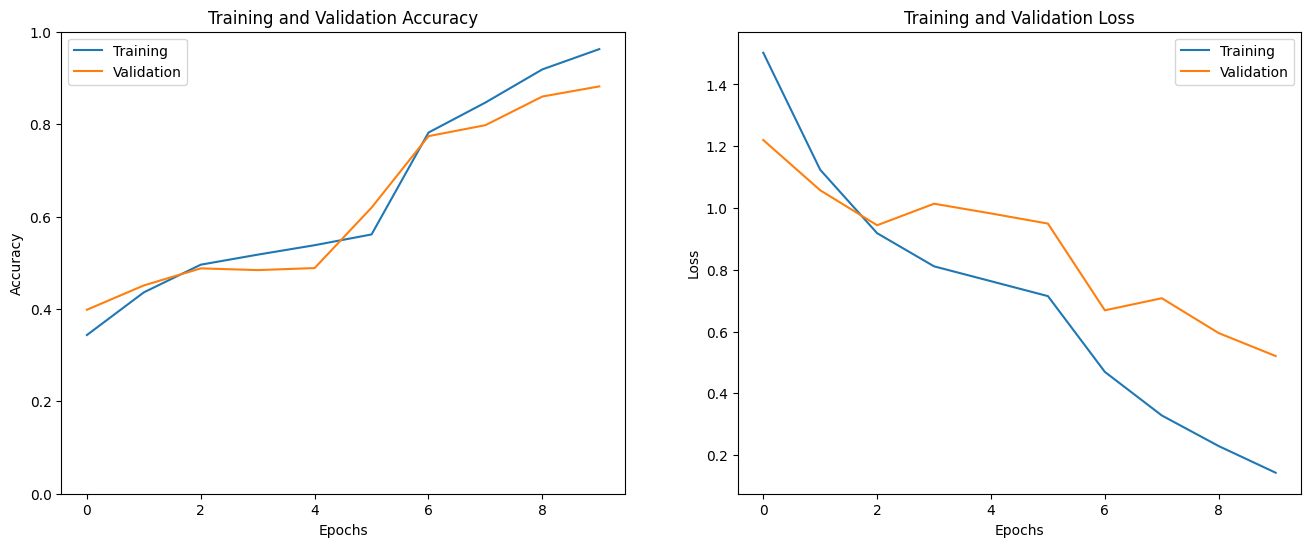

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8745 - loss: 0.5823
Test Loss: 0.6001296639442444
Test Accuracy: 0.8730000257492065
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

     sadness       0.93      0.92      0.93       581
         joy       0.93      0.85      0.89       695
        love       0.64      0.82      0.72       159
       anger       0.87      0.88      0.87       275
        fear       0.85      0.87      0.86       224
    surprise       0.65      0.76      0.70        66

    accuracy                           0.87      2000
   macro avg       0.81      0.85      0.83      2000
weighted avg       0.88      0.87      0.88      2000



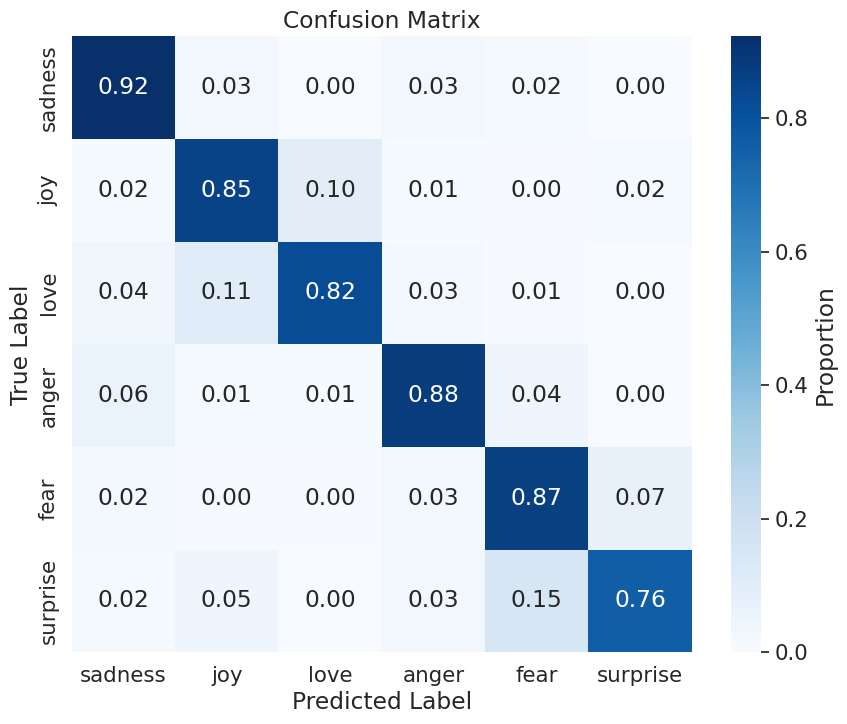

In [ ]:
# Visualize training history
show_history(history_model_lstm_1)

# Evaluating the model
loss, accuracy = model_lstm_1.evaluate(padded_test_sequences, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_lstm_1.predict(padded_test_sequences)
y_pred_classes_lstm = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes_lstm, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(test_labels, y_pred_classes_lstm, classes=list(labels_dict.values()))

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
test_labels_encoded = to_categorical(test_labels, num_classes=6)

**GRU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D

def create_enhanced_gru_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(Bidirectional(GRU(128, return_sequences=True)))  # Bidirectional GRU
    model.add(GlobalMaxPooling1D())  # Global Max Pooling
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))  # Dense layer for more complexity
    model.add(Dropout(0.5))  # Another Dropout layer
    model.add(Dense(6, activation='softmax'))  # Output layer for multi-class classification

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Create the enhanced model
model_enhanced_gru = create_enhanced_gru_model(vocab_size, embedding_dim, 50)

# Summary of the enhanced model
model_enhanced_gru.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4063 - loss: 1.4436 - val_accuracy: 0.8860 - val_loss: 0.3411
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8906 - loss: 0.3337 - val_accuracy: 0.9023 - val_loss: 0.2489
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9322 - loss: 0.2011 - val_accuracy: 0.9080 - val_loss: 0.2904
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9470 - loss: 0.1455 - val_accuracy: 0.9036 - val_loss: 0.2879
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9625 - loss: 0.1097 - val_accuracy: 0.8929 - val_loss: 0.3277
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9042 - loss: 0.2490
Test Loss: 0.25507795810699463
Test Accuracy: 0.9049999713897705
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


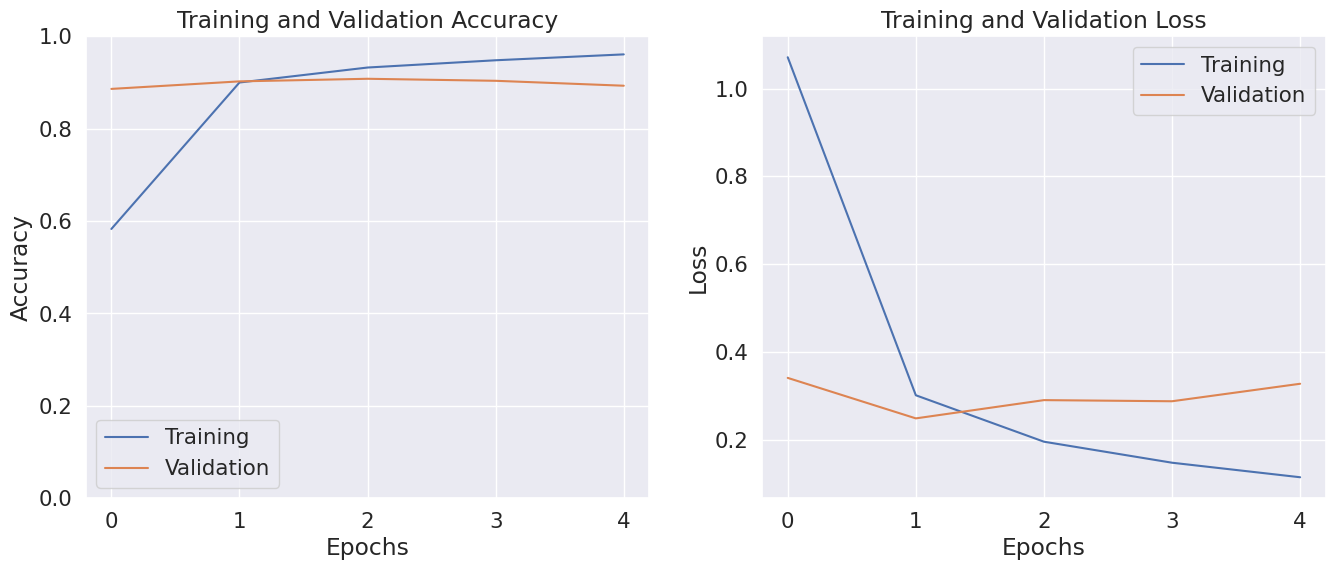

Classification Report:
              precision    recall  f1-score   support

     sadness       0.95      0.93      0.94       581
         joy       0.92      0.93      0.93       695
        love       0.77      0.79      0.78       159
       anger       0.91      0.89      0.90       275
        fear       0.87      0.92      0.90       224
    surprise       0.75      0.70      0.72        66

    accuracy                           0.91      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.91      0.91      0.90      2000



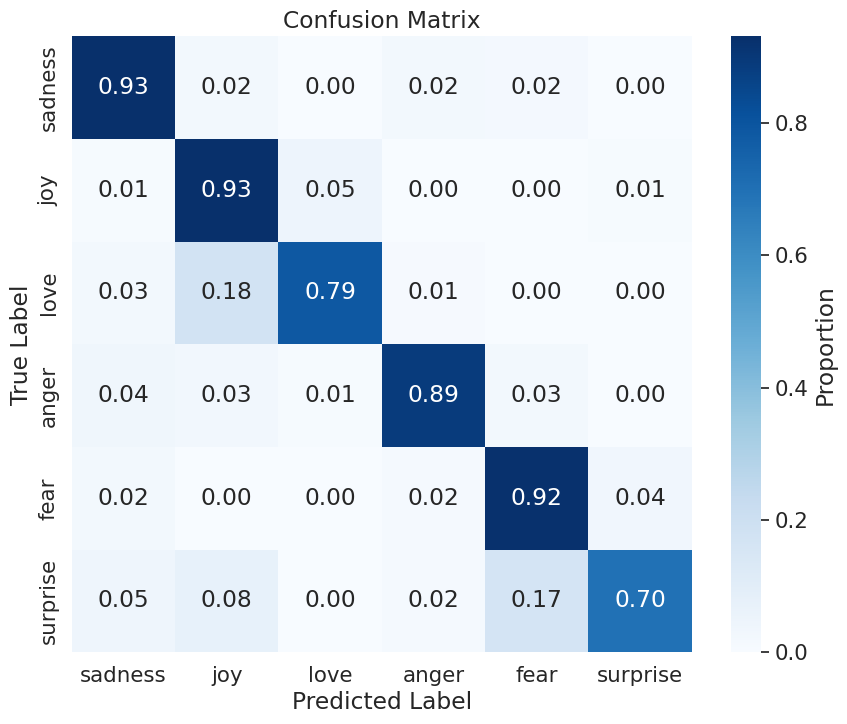

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=6)
y_val_encoded = to_categorical(y_val, num_classes=6)
test_labels_encoded = to_categorical(test_labels, num_classes=6)

history_model_gru = model_enhanced_gru.fit(X_train,
                                  y_train_encoded,
                                  epochs=20,
                                  batch_size=32,
                                  validation_data=(X_val, y_val_encoded),
                                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

# Evaluating the model
loss, accuracy = model_enhanced_gru.evaluate(padded_test_sequences, test_labels_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_enhanced_gru.predict(padded_test_sequences)
y_pred_classes_gru = np.argmax(y_pred, axis=1)

show_history(history_model_gru)

print("Classification Report:")
print(classification_report(test_labels, y_pred_classes_gru, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(test_labels, y_pred_classes_gru, classes=list(labels_dict.values()))


**CNN**

In [ ]:
# Define the CNN model
def create_cnn_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#vocabulary size
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Create the CNN model
model_cnn = create_cnn_model(vocab_size, embedding_dim, max_len)

# Summary of the CNN model
model_cnn.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model
history_model_cnn = model_cnn.fit(X_train,
                         y_train,
                         epochs=10,
                         batch_size=32,
                         validation_data=(X_val, y_val),
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.3652 - loss: 1.4782 - val_accuracy: 0.6425 - val_loss: 0.8990
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7064 - loss: 0.7063 - val_accuracy: 0.7765 - val_loss: 0.5822
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8456 - loss: 0.3940 - val_accuracy: 0.8779 - val_loss: 0.4174
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9368 - loss: 0.1995 - val_accuracy: 0.8785 - val_loss: 0.4135
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9625 - loss: 0.1147 - val_accuracy: 0.8860 - val_loss: 0.4659
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9777 - loss: 0.0716 - val_accuracy: 0.8754 - val_loss: 0.5966
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9780 - loss: 0.0669 - val_accuracy: 0.8817 - val_loss: 0.7017


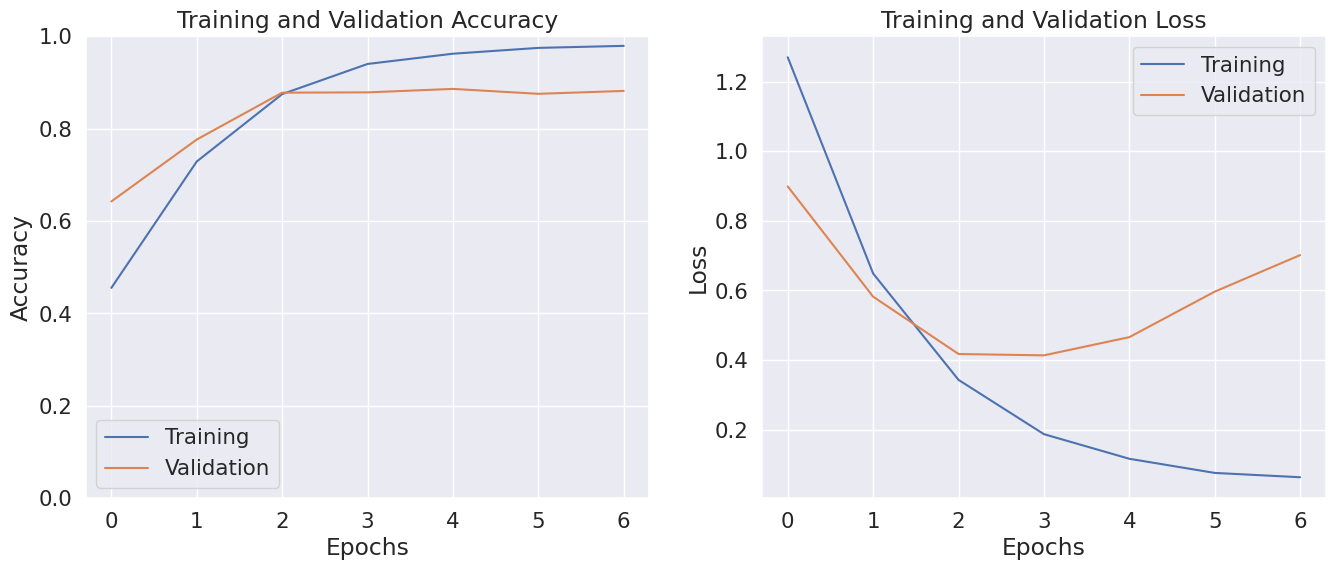

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8743 - loss: 0.4598
Test Loss: 0.4422067403793335
Test Accuracy: 0.8755000233650208
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.88      0.92       581
         joy       0.92      0.91      0.91       695
        love       0.70      0.70      0.70       159
       anger       0.83      0.91      0.87       275
        fear       0.81      0.90      0.85       224
    surprise       0.63      0.62      0.63        66

    accuracy                           0.88      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.88      0.88      0.88      2000



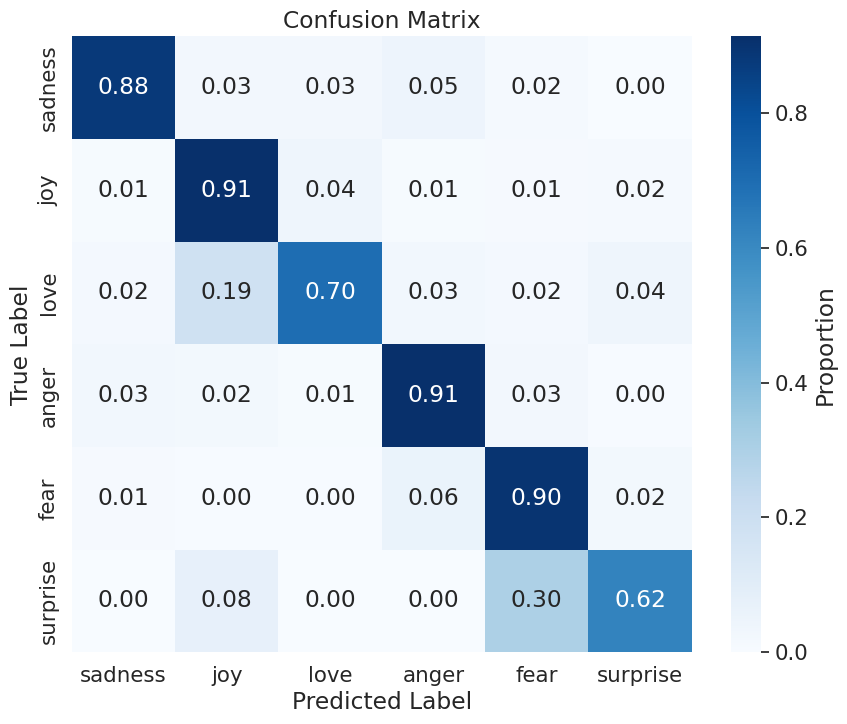

In [ ]:
# Visualize training history
show_history(history_model_cnn)

# Evaluating the model
loss, accuracy = model_cnn.evaluate(padded_test_sequences, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_cnn.predict(padded_test_sequences)
y_pred_classes_cnn = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes_cnn, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(test_labels, y_pred_classes_cnn, classes=list(labels_dict.values()))

**Bidirectional LSTM Model 2**


In [ ]:
import tensorflow as tf

def create_bidirectional_lstm_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = 10000
embedding_dim = 128
max_len = 50

model_bidirectional_lstm = create_bidirectional_lstm_model(vocab_size, embedding_dim, max_len)

model_bidirectional_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train,
                                                           y_train,
                                                           epochs=15,
                                                           batch_size=32,
                                                           validation_data=(X_val, y_val),
                                                           callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.3423 - loss: 1.5478 - val_accuracy: 0.7101 - val_loss: 0.7463
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7390 - loss: 0.6634 - val_accuracy: 0.8053 - val_loss: 0.5194
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8440 - loss: 0.4348 - val_accuracy: 0.8798 - val_loss: 0.3656
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9246 - loss: 0.2522 - val_accuracy: 0.8948 - val_loss: 0.3695
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9483 - loss: 0.1787 - val_accuracy: 0.8929 - val_loss: 0.3935
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9569 - loss: 0.1466 - val_accuracy: 0.8898 - val_loss: 0.4542


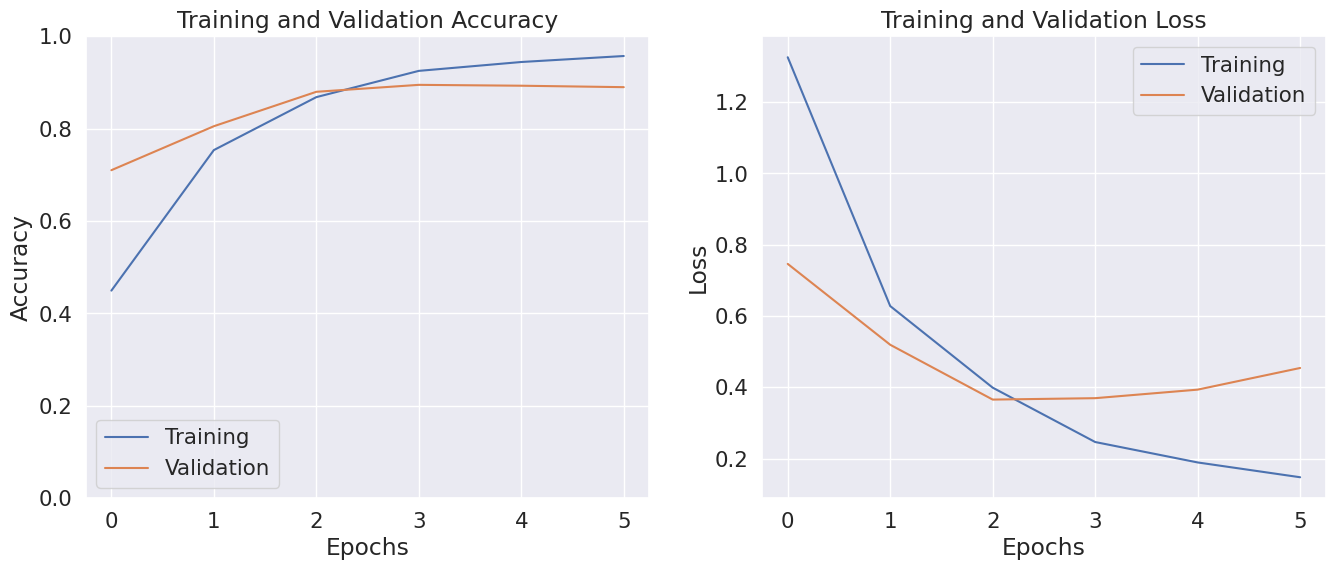

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8795 - loss: 0.3675
Test Loss: 0.3961077928543091
Test Accuracy: 0.8709999918937683
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Classification Report:
              precision    recall  f1-score   support

     sadness       0.94      0.93      0.93       581
         joy       0.93      0.90      0.91       695
        love       0.68      0.74      0.70       159
       anger       0.88      0.83      0.85       275
        fear       0.76      0.94      0.84       224
    surprise       0.52      0.38      0.44        66

    accuracy                           0.87      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.87      0.87      0.87      2000



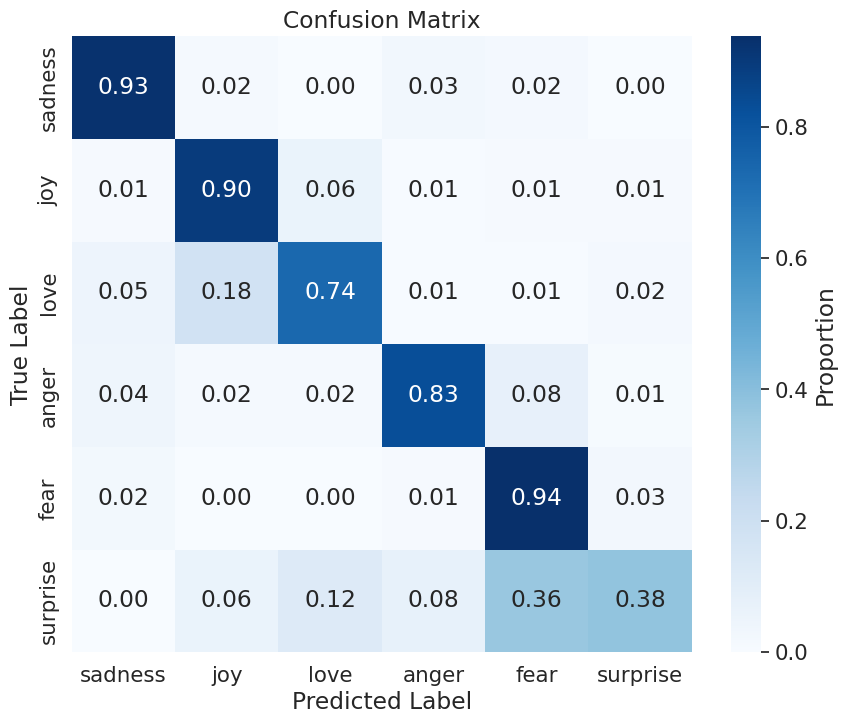

In [ ]:
# Visualize training history
show_history(history_bidirectional_lstm)

# Evaluating the model
loss, accuracy = model_bidirectional_lstm.evaluate(padded_test_sequences, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_bidirectional_lstm.predict(padded_test_sequences)
y_pred_classes_bilstm = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes_bilstm, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(test_labels, y_pred_classes_bilstm, classes=list(labels_dict.values()))

# **CNN+LSTM**



In [ ]:
import tensorflow as tf

def create_cnn_lstm_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_lstm_model = create_cnn_lstm_model(vocab_size=10000, embedding_dim=128, input_length=max_len)
cnn_lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3142 - loss: 1.6036 - val_accuracy: 0.4427 - val_loss: 1.1484
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4658 - loss: 1.0861 - val_accuracy: 0.5204 - val_loss: 0.9793
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5787 - loss: 0.8581 - val_accuracy: 0.5723 - val_loss: 0.9481
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7081 - loss: 0.6817 - val_accuracy: 0.8028 - val_loss: 0.6535
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8882 - loss: 0.3829 - val_accuracy: 0.8428 - val_loss: 0.5027
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9387 - loss: 0.2173 - val_accuracy: 0.8685 - val_loss: 0.5942
Epoch 7/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9450 - loss: 0.1880 - val_accuracy: 0.8604 - val_loss: 0.5995
Epoch 8/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9625 - loss: 0.1380 - val_accuracy

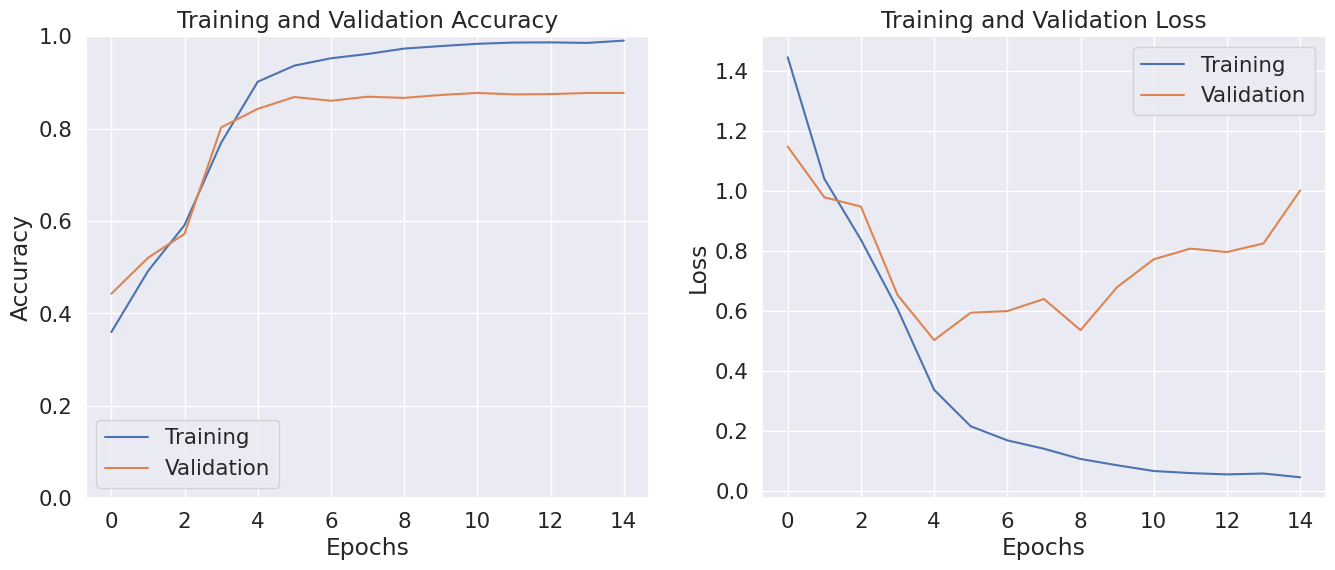

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 1.0988
Test Loss: 0.9895626306533813
Test Accuracy: 0.875
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

     sadness       0.94      0.92      0.93       581
         joy       0.90      0.92      0.91       695
        love       0.74      0.65      0.69       159
       anger       0.87      0.88      0.87       275
        fear       0.84      0.87      0.85       224
    surprise       0.55      0.59      0.57        66

    accuracy                           0.88      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.87      0.88      0.87      2000



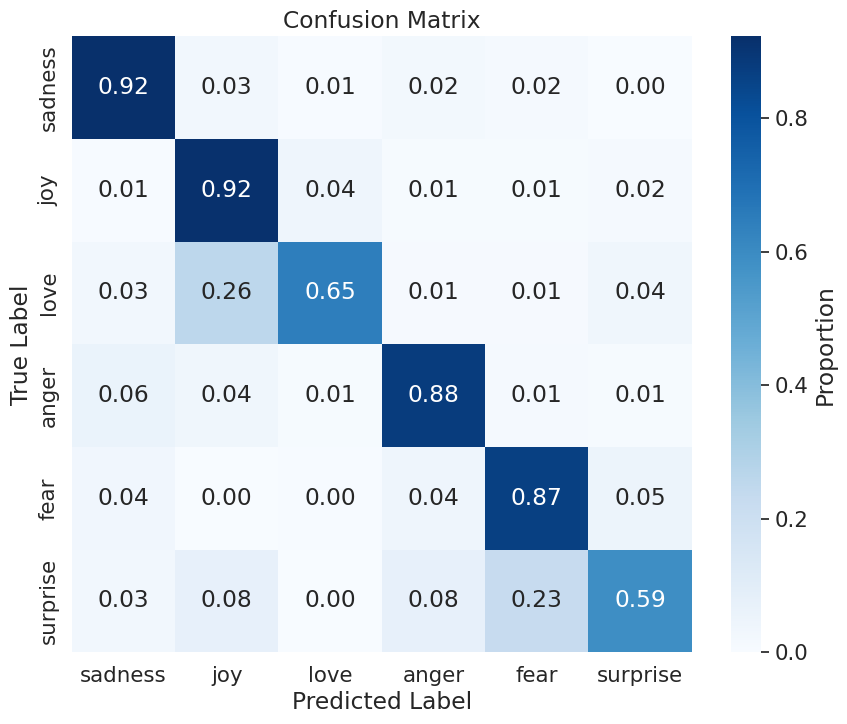

In [ ]:
# Visualize training history
show_history(history_cnn_lstm)

# Evaluating the model
loss, accuracy = cnn_lstm_model.evaluate(padded_test_sequences, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = cnn_lstm_model.predict(padded_test_sequences)
y_pred_classes_cnn_lstm = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes_cnn_lstm, target_names=list(labels_dict.values())))

# Displaying confusion matrix
show_confusion_matrix(test_labels, y_pred_classes_cnn_lstm, classes=list(labels_dict.values()))

In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

In [ ]:
def create_improved_gru_cnn_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([

        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),


        layers.Bidirectional(layers.GRU(128, return_sequences=True)),
        layers.BatchNormalization(),

        layers.Conv1D(filters=512, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=512, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        layers.GlobalMaxPooling1D(),

        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(6, activation='softmax')
    ])
    return model


In [ ]:
# Define model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Create the GRU + CNN model
model_gru_cnn = create_improved_gru_cnn_model(vocab_size, embedding_dim, max_len)

# Display the model summary
model_gru_cnn.summary()

model_gru_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the GRU + CNN model
history_model_gru_cnn = model_gru_cnn.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9799 - loss: 0.0601 - val_accuracy: 0.8867 - val_loss: 0.3902
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9809 - loss: 0.0594 - val_accuracy: 0.8560 - val_loss: 0.5497
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9697 - loss: 0.0886 - val_accuracy: 0.8798 - val_loss: 0.4645
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9800 - loss: 0.0580 - val_accuracy: 0.8810 - val_loss: 0.5275
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9869 - loss: 0.0429 - val_accuracy: 0.8679 - val_loss: 0.5289
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9757 - loss: 0.0665 - val_accuracy: 0.8961 - val_loss: 0.4676
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9850 - loss: 0.0481 - val_accuracy: 0.8860 - val_loss: 0.4598
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9871 - loss: 0.0396 - val_ac

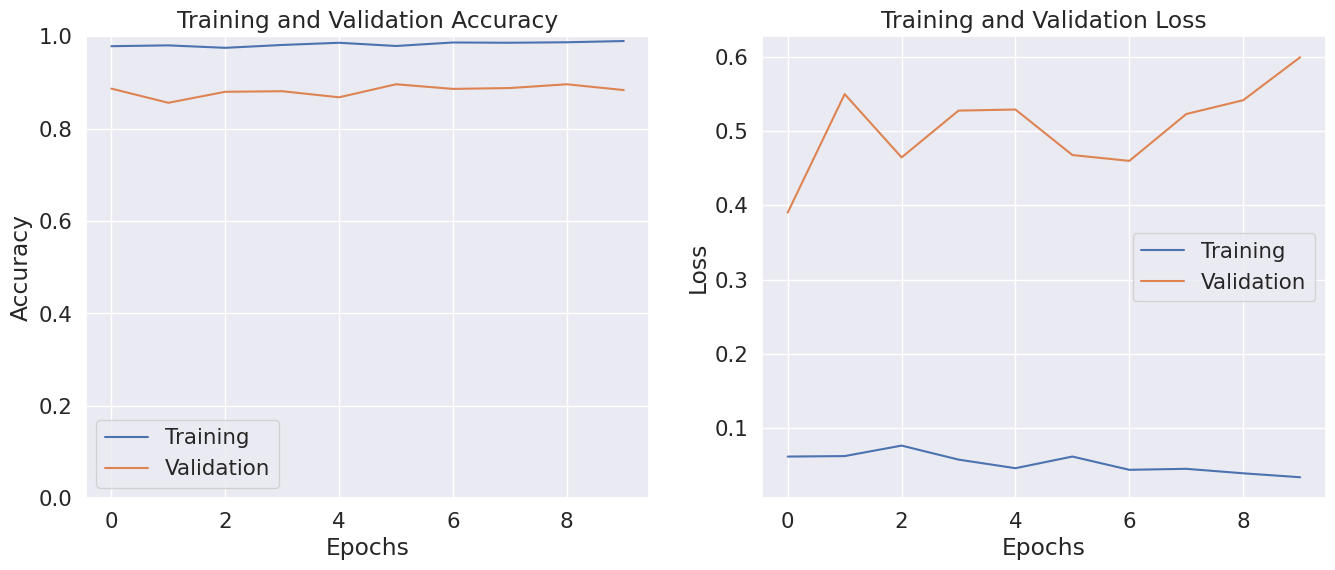

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8638 - loss: 0.6765
Test Loss: 0.6709635853767395
Test Accuracy: 0.8705000281333923
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.90      0.93       581
         joy       0.92      0.89      0.90       695
        love       0.58      0.84      0.69       159
       anger       0.85      0.91      0.88       275
        fear       0.94      0.75      0.84       224
    surprise       0.64      0.77      0.70        66

    accuracy                           0.87      2000
   macro avg       0.81      0.84      0.82      2000
weighted avg       0.89      0.87      0.87      2000



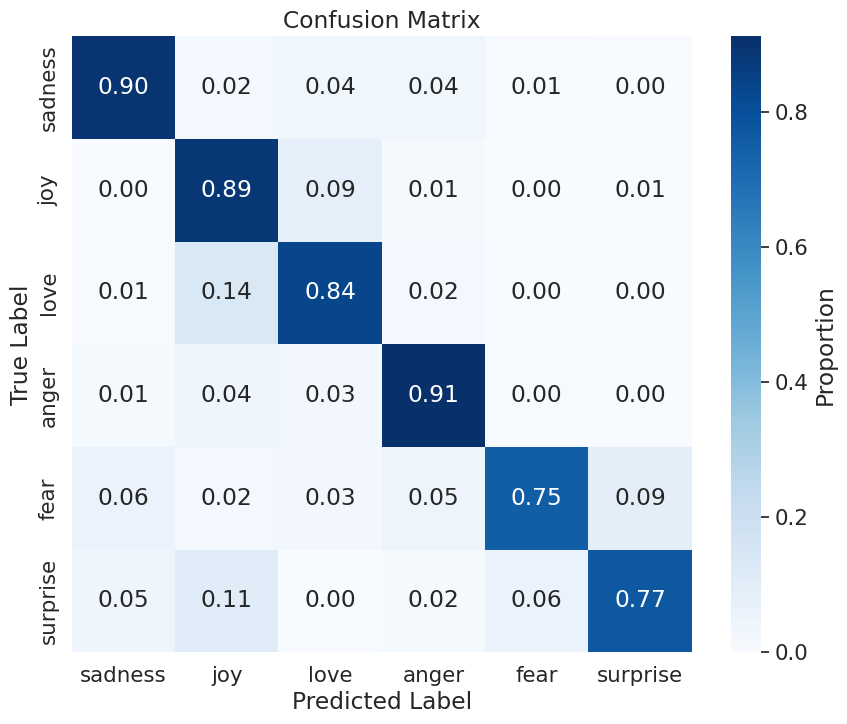

In [ ]:
# Visualize training history
show_history(history_model_gru_cnn)

# Evaluate the model on the test set
loss, accuracy = model_gru_cnn.evaluate(padded_test_sequences, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = model_gru_cnn.predict(padded_test_sequences)
y_pred_classes_gru_cnn = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes_gru_cnn, target_names=list(labels_dict.values())))

# Display confusion matrix
show_confusion_matrix(test_labels, y_pred_classes_gru_cnn, classes=list(labels_dict.values()))

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.7 MB/s eta 0:00:00


# **PREDICTIONS**

In [ ]:
# Saving the trained model
model_enhanced_gru.save('tweet_classification_model_gru.h5')
print("Model saved successfully.")

In [ ]:
from tensorflow.keras.models import load_model
def load_model_from_file(filename):
    model = load_model(filename)
    print(f'Model loaded from {filename}')
    return model

In [ ]:
loaded_model = load_model_from_file('/content/drive/MyDrive/minor project/tweet_classification_model_gru.h5')

In [ ]:
loss, accuracy = loaded_model.evaluate(padded_test_sequences, test_labels_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
def predict_emotion(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    padded_input = pad_sequences(input_seq, maxlen=50)
    prediction = loaded_model.predict(padded_input)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

In [ ]:
while True:
    user_input = input("Enter a sentence to predict emotion (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    predicted_class = predict_emotion(user_input)
    emotion = list(labels_dict.values())[predicted_class]
    print(f'Predicted Emotion: {emotion}')

In [ ]:
import matplotlib.pyplot as plt

# function to plot training and validation accuracy/loss across all models
def plot_comparative_metrics(histories, metric, title, ylabel):
    plt.figure(figsize=(12, 8))
    for model_name, history in histories.items():
        epochs = range(1, len(history.history[metric]) + 1)
        plt.plot(epochs, history.history[metric], label=f'{model_name} - Training')
        plt.plot(epochs, history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - Validation')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

model_histories = {
    "LSTM Model": history_model_lstm_1,
    "GRU Model": history_model_gru,
    "CNN Model": history_model_cnn,
    "Bidirectional LSTM Model": history_bidirectional_lstm,
    "CNN+LSTM Model": history_cnn_lstm,
    "GRU+CNN Model": history_model_gru_cnn
}

plot_comparative_metrics(model_histories, 'accuracy', 'Model Comparison: Accuracy over Epochs', 'Accuracy')
plot_comparative_metrics(model_histories, 'loss', 'Model Comparison: Loss over Epochs', 'Loss')


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

model_predictions = {
    "LSTM Model": y_pred_classes_lstm,
    "GRU Model": y_pred_classes_gru,
    "CNN Model": y_pred_classes_cnn,
    "Bidirectional LSTM Model": y_pred_classes_bilstm,
    "CNN+LSTM Model": y_pred_classes_cnn_lstm,
    "GRU+CNN Model": y_pred_classes_gru_cnn
}

metrics_df = pd.DataFrame()
for model_name, y_pred in model_predictions.items():
    report = classification_report(test_labels, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df["model"] = model_name
    metrics_df = pd.concat([metrics_df, df])

# Plot the metrics
for metric in ["precision", "recall", "f1-score"]:
    plt.figure(figsize=(12, 6))
    for model_name in model_predictions.keys():
        plt.bar(
            metrics_df[metrics_df["model"] == model_name].index[:-1],
            metrics_df[metrics_df["model"] == model_name][metric][:-1],
            label=model_name
        )
    plt.title(f'Comparative {metric.capitalize()} across Models')
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()
